## Modelo Futuros Mini Ibovespa - Dados Históricos


O Mercado Futuro é o ambiente onde você pode ganhar com a alta ou baixa de um determinado ativo, seja ele uma commodity (Milho, Café, Boi Gordo), uma moeda (como o dólar), um Índice (Bovespa, Índice S&P 500) ou mesmo uma taxa de juros. Nele, são negociados contratos futuros.

<br><img src="grafico.jpeg"><br>

O mini índice é um contrato futuro derivado do Índice Bovespa, ou seja, é um ativo que tem como base o sobe e desce desse índice. Como esse tipo de operação envolve **risco considerável** e **oscilações frequentes no mercado**, ela é indicada apenas para aqueles que se encaixam no perfil de investidor arrojado.

Neste trabalho iremos implementar uma RNNs para realizar a predição diária do Mini Índice da Ibovespa.

O dataset **"FuturosMiniBovespa.csv"** possui informações dispostas em colunas :

* **Date**:  Data das operações na bolsa (diária)
* **Close**:  Valor de Fechamento do Índice da Ibovespa (no dia)
* **Open**:  Valor da Abertura do Índice da Ibovespa (no dia)
* **High**:  Valor máximo do Índice da Ibovespa (no dia)
* **Low**:  Valor mínimo do Índice da Ibovespa (no dia)
* **Vol**:  Volume de contratos negociados (no dia)




### Bibliotecas

In [29]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import plotly.graph_objects as go 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carregando os dados

Vamos começar lendo o arquivo FuturosMiniBovespa.csv em um dataframe do pandas, mas antes vamos dar uma olhadinha no gráfico de variação do último mês do índice Ibovespa.

In [30]:
DataSet=pd.read_csv('Futuros Mini Ibovespa - teste.csv')

In [31]:
fig = go.Figure(data=[go.Candlestick(x=DataSet['Date'],
                open=DataSet['Open'], high=DataSet['High'],
                low=DataSet['Low'], close=DataSet['Close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)  
fig.show()



## Rede Neural Recorrente (RNN)

Antes de avançar para LSTM, primeiro vamos introduzir o conceito de Redes Recorrentes. Elas são redes utilizadas para reconhecer padrões quando os resultados do passado influenciam no resultado atual. Um exemplo disso são as séries temporais, em que a ordem dos dados é muito importante. <br>

Nesta arquitetura, um neurônio tem como entrada seu estado anterior, além das entradas da camada anterior. A imagem abaixo ilustra esta nova modelagem.
<br><img src="Arquitetura RNN.png"><br>

Observe que H representa o estado. Assim, no estado H_1, o neurônio recebe como parâmetro de entrada X_1 e, além disso, seu estado anterior H_0. O principal problema desta arquitetura é que os estados mais antigos são esquecidos muito rapidamente. Ou seja, para sequências em que precisamos lembrar além de um passado imediato, as redes RNNs são limitadas.


### Rede LSTM
Uma rede LSTM tem origem em uma RNN (Rede Neural Recorrente). Mas ela resolve o problema de memória mudando sua arquitetura.

<br><img src="Arquitetura LSTM.png"><br>

Nesta nova arquitetura, cada neurônio possui 3 gates, cada um com uma função diferente. São eles:
* Input Gate
* Output Gate
* Forget Gate

Agora, um neurônio LSTM recebe entradas de seu estado anterior, assim como ocorria na Rede Recorrente:
<br><img src="Desdobramento LSTM.png"><br>


### Agora vamos ler o arquivo do período desejável 

In [44]:
DataSet=pd.read_csv('Futuros Mini Ibovespa - treino.csv')
DataSet=DataSet.dropna()
DataSet.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-29,54317.0,54705.0,53592.0,53911.0,53911.0,4898400.0
1,2016-05-02,53910.0,54113.0,53265.0,53562.0,53562.0,3286100.0
2,2016-05-03,53557.0,53557.0,52260.0,52260.0,52260.0,3892400.0
3,2016-05-04,52253.0,52672.0,51931.0,52553.0,52553.0,4263800.0
4,2016-05-05,52569.0,53071.0,51311.0,51671.0,51671.0,3653100.0


In [45]:
DataSet.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1215.000000,1215.000000,1215.000000,1215.000000,1215.000000,1.215000e+03
mean,84360.849383,85211.411523,83553.652675,84416.558848,84416.558848,5.270025e+06
std,19102.623166,19240.391908,18955.959496,19113.984697,19113.984697,3.090103e+06
min,48468.000000,49057.000000,48067.000000,48472.000000,48472.000000,0.000000e+00
25%,66890.500000,67493.000000,66188.000000,66933.000000,66933.000000,3.275200e+06
50%,84090.000000,85110.000000,83377.000000,84164.000000,84164.000000,4.136800e+06
75%,100096.500000,101163.500000,99290.000000,100098.000000,100098.000000,6.174500e+06
max,125075.000000,125324.000000,123227.000000,125077.000000,125077.000000,2.176870e+07


### Inicialmente iremos criar uma RNN baseada apenas no Valor de Abertura

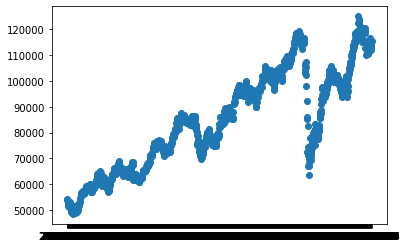

In [46]:
plt.scatter(DataSet['Date'],DataSet['Open'],)
plt.show()

base_treinamento = DataSet.iloc[:, 1:2].values

#DataSet.drop(['Date','Close','High','Low', 'Volume'],axis=1,inplace=True)

In [47]:
base_treinamento

array([[ 54317.],
       [ 53910.],
       [ 53557.],
       ...,
       [113750.],
       [114776.],
       [115414.]])

### Normalizar os dados do Mini Índice

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
DataScaled=scaler.fit_transform(base_treinamento)

In [49]:
print(DataScaled)

[[0.07635073]
 [0.07103789]
 [0.06642996]
 ...
 [0.85216756]
 [0.86556059]
 [0.87388881]]


### Definição dos previsores

In [50]:
previsores = []
preco_real = []
NRecursao = 90
DataSetLen = len(DataScaled)
print(DataSetLen)

1215


In [51]:

for i in range(NRecursao, DataSetLen):
    previsores.append(DataScaled[i-NRecursao:i,0])
    preco_real.append(DataScaled[i,0])

previsores, preco_real = np.array(previsores), np.array(preco_real)

In [52]:
previsores.shape

(1125, 90)

### Tranformar para o formato do Tensor do Keras

<br><img src="TensorKeras.png"><br>

In [53]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [54]:
previsores.shape

(1125, 90, 1)

### Estrutura da Rede Neural

In [55]:
# Camada de entrada
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

# Cada Oculta 1
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Cada Oculta 3
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

# Camada de Saída
regressor.add(Dense(units = 1, activation = 'linear'))


### Construindo a Rede

In [57]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs = 20, batch_size = 32)

Epoch 1/20
1125/1125 [==============================] - 26s 24ms/step - loss: 0.0082 - mean_absolute_error: 0.0659
Epoch 2/20
1125/1125 [==============================] - 25s 22ms/step - loss: 0.0074 - mean_absolute_error: 0.0629
Epoch 3/20
1125/1125 [==============================] - 25s 22ms/step - loss: 0.0067 - mean_absolute_error: 0.0603
Epoch 4/20
1125/1125 [==============================] - 24s 22ms/step - loss: 0.0064 - mean_absolute_error: 0.0589
Epoch 5/20
1125/1125 [==============================] - 26s 24ms/step - loss: 0.0058 - mean_absolute_error: 0.0558
Epoch 6/20
1125/1125 [==============================] - 24s 21ms/step - loss: 0.0062 - mean_absolute_error: 0.0570
Epoch 7/20
1125/1125 [==============================] - 26s 23ms/step - loss: 0.0055 - mean_absolute_error: 0.0547
Epoch 8/20
1125/1125 [==============================] - 24s 21ms/step - loss: 0.0052 - mean_absolute_error: 0.0526
Epoch 9/20
1125/1125 [==============================] - 25s 22ms/step - loss: 0.

### Conjunto de dados para o Teste

In [58]:
DataSet_teste=pd.read_csv('Futuros Mini Ibovespa - teste.csv')

preco_real_teste = DataSet_teste.iloc[:, 1:2].values

base_completa = pd.concat((DataSet['Open'], DataSet_teste['Open']), axis = 0)
entradas = base_completa[len(base_completa) - len(DataSet_teste) - NRecursao:].values

entradas = entradas.reshape(-1, 1)
entradas = scaler.transform(entradas)

In [59]:
DataSetTestLen = len(DataSet_teste)
NPredictions = 90

X_teste = []
for i in range(NRecursao, DataSetTestLen+NRecursao):
    X_teste.append(entradas[i-NRecursao:i, 0])
    
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

previsoes = regressor.predict(X_teste)
previsoes = scaler.inverse_transform(previsoes)


In [ ]:
RNN=[]
predictions_teste=X_teste[0].T
predictions_teste=np.reshape(predictions_teste, (predictions_teste.shape[0], predictions_teste.shape[1], 1))

predictions_teste[0][NRecursao-1][0]=regressor.predict(predictions_teste)[0][0]
RNN.append(regressor.predict(predictions_teste)[0])

for i in range(NPredictions-1):
    predictions_teste=np.roll(predictions_teste,-1)
    predictions_teste[0][NRecursao-1][0]=regressor.predict(predictions_teste)[0][0]
    RNN.append(regressor.predict(predictions_teste)[0])
RNN = scaler.inverse_transform(RNN)

print(RNN.mean())
print(previsoes.mean())
print(preco_real_teste.mean())

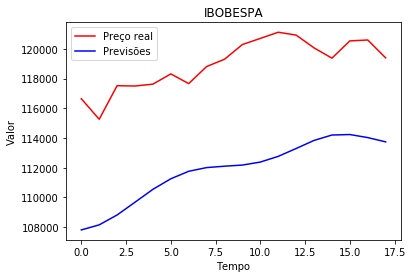

In [60]:
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
#plt.plot(RNN, color = 'green', label = 'RNN')

plt.title('IBOBESPA')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [ ]:
np.shape(previsoes)